# UW-Madison GI Tract Image Segmentation のための前処理コード
https://www.kaggle.com/competitions/uw-madison-gi-tract-image-segmentation/overview

2024.07.05, MUTO Yoshihiko

In [1]:
# train.csv の読み込み
dataset_dir = 'uw-madison-gi-tract-image-segmentation'

import pandas as pd
df = pd.read_csv(dataset_dir + '/train.csv')
df.head()

id        class segmentation
0  case123_day20_slice_0001  large_bowel          NaN
1  case123_day20_slice_0001  small_bowel          NaN
2  case123_day20_slice_0001      stomach          NaN
3  case123_day20_slice_0002  large_bowel          NaN
4  case123_day20_slice_0002  small_bowel          NaN

In [2]:
# データ数および background のみのスライスを確認
print("slice x class: ", len(df))
print("no segmentation:", df['segmentation'].isnull().sum())

slice x class:  115488
no segmentation: 81575


全部で 115,488件のラベル付け。このうち segmentation がなされているのは 81,575件。

In [3]:
# スライス数
print("# slices: ", len(df['id'].unique()))

# slices:  38496


In [4]:
# スライス集合
slices = df['id'].unique()
slices

array(['case123_day20_slice_0001', 'case123_day20_slice_0002',
       'case123_day20_slice_0003', ..., 'case30_day0_slice_0142',
       'case30_day0_slice_0143', 'case30_day0_slice_0144'], dtype=object)

In [5]:
# ひとつのスライスは，large_bowel, small_bowel, stomach に分離されている
df_slice = df.copy()
df_slice = df_slice[df['id']==slices[0]]
df_slice

id        class segmentation
0  case123_day20_slice_0001  large_bowel          NaN
1  case123_day20_slice_0001  small_bowel          NaN
2  case123_day20_slice_0001      stomach          NaN

### スライスひとつに対する処理

In [6]:
case, day, _, slice_number = slices[0].split('_') # ['case123', 'day20', 'slice', '0001']
path = f"{dataset_dir}/train/{case}/{case}_{day}/scans/slice_{slice_number}*.png"

In [7]:
# 画像サイズ等の情報が予め取れないため，glob で正確なパス名を取ってくる
import glob
exact_path = glob.glob(path)[0] # 1つしか見つからないはず!!!
exact_path

'uw-madison-gi-tract-image-segmentation/train/case123/case123_day20/scans/slice_0001_266_266_1.50_1.50.png'

In [8]:
# スライスに関する情報
slice_info = exact_path.split('/')[-1].replace('.png', '') # 'slice_0001_266_266_1.50_1.50'
slice_data = slice_info.split('_')
slice_width = int(slice_data[2])
slice_height = int(slice_data[3])
width_pixel_spacing = float(slice_data[4])
height_pixel_spacing = float(slice_data[5])

print("slice width: {} pixels".format(slice_width))
print("slice height: {} pixels".format(slice_height))
print("width pixel spacing: {} mm".format(width_pixel_spacing))
print("height pixel spacing: {} mm".format(height_pixel_spacing))


slice width: 266 pixels
slice height: 266 pixels
width pixel spacing: 1.5 mm
height pixel spacing: 1.5 mm


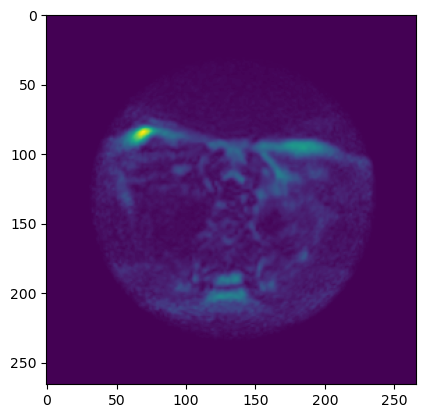

In [9]:
# スライス（画像）の表示
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open(exact_path)
plt.imshow(img)

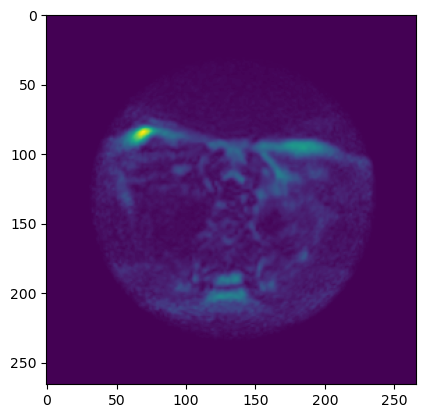

In [12]:
import numpy as np
import cv2
def load_img(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    img = np.expand_dims(img, axis=2)
    img = img.astype('float32') # original is uint16
    mx = np.max(img)
    if mx:
        img/=mx # scale image to [0, 1]
    return img

img = load_img(exact_path)

import matplotlib.pyplot as plt
plt.imshow(img)

### マスクを取り出す

In [13]:
tmp_df = df.copy()
tmp_df = tmp_df.dropna()
tmp_df

id        class  \
194     case123_day20_slice_0065      stomach   
197     case123_day20_slice_0066      stomach   
200     case123_day20_slice_0067      stomach   
203     case123_day20_slice_0068      stomach   
206     case123_day20_slice_0069      stomach   
...                          ...          ...   
115459    case30_day0_slice_0135  small_bowel   
115461    case30_day0_slice_0136  large_bowel   
115462    case30_day0_slice_0136  small_bowel   
115464    case30_day0_slice_0137  large_bowel   
115465    case30_day0_slice_0137  small_bowel   

                                             segmentation  
194     28094 3 28358 7 28623 9 28889 9 29155 9 29421 ...  
197     27561 8 27825 11 28090 13 28355 14 28620 15 28...  
200     15323 4 15587 8 15852 10 16117 11 16383 12 166...  
203     14792 5 15056 9 15321 11 15587 11 15852 13 161...  
206     14526 6 14789 12 15054 14 15319 16 15584 17 15...  
...                                                   ...  
115459  22540 1 22804 5 23069 7 23334 10 23600 11 2386...  
115461  18746 7 19009 23 19038 7 19273 44 19537 49 198...  
115462  23079 1 23343 6 23608 9 23874 11 24139 13 2440...  
115464  18746 2 19010 8 19040 3 19274 25 19302 12 1953...  
115465  21457 6 21722 10 21987 15 22252 18 22517 21 22...  

[33913 rows x 3 columns]

In [14]:
target_slice = 'case123_day20_slice_0091'
target_df = df.copy()
target_df = target_df[df['id'] == target_slice]
target_df

id        class  \
270  case123_day20_slice_0091  large_bowel   
271  case123_day20_slice_0091  small_bowel   
272  case123_day20_slice_0091      stomach   

                                          segmentation  
270  15334 4 15599 7 15864 10 16130 12 16146 4 1615...  
271  20095 6 20360 9 20625 11 20890 13 21156 13 214...  
272  11846 1 12107 11 12371 15 12636 17 12901 21 13...

## これが本ちゃんのコード !!!
- annotation (RLE形式)を処理する関数
- 撮像された画像およびマスクを生成する関数 load_image()

In [15]:
# RLE により annotation されているから，それを展開するコード
# (メモ) rle_decode() のみ用いる
import numpy as np

# 下記サイトのコードを改造
# https://www.kaggle.com/code/paulorzp/run-length-encode-and-decode
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)
 
def rle_decode(mask_rle, height, width, brightness=1):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(height * width, dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = brightness
    return img.reshape((height, width))

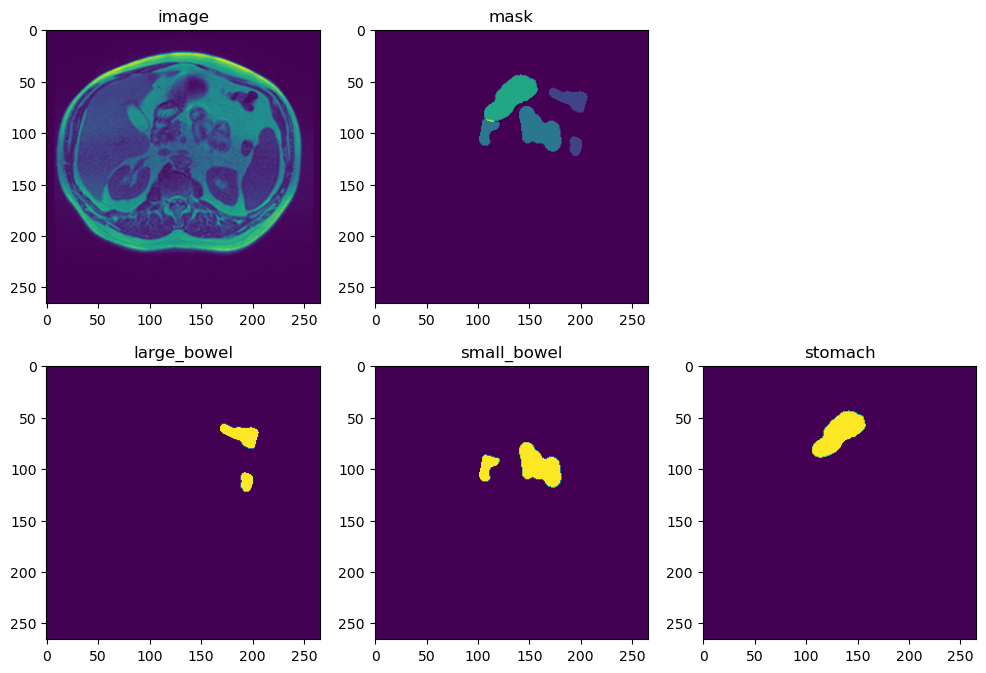

In [16]:
# 画像とマスクを取り出すための関数
DEBUG = False

def load_image(df, target_slice='case123_day20_slice_0091'):
    # train.csv を読み込んだデータフレームから，target_slice と一致するレコードを取り出す
    target_df = df.copy()
    target_df = target_df[df['id'] == target_slice]

    # 画像サイズを取り出すため，画像へのパスを設定
    case, day, _, slice_number = target_slice.split('_') # ['case123', 'day20', 'slice', '0091']
    image_path = f"{dataset_dir}/train/{case}/{case}_{day}/scans/slice_{slice_number}*.png"

    # 画像サイズ等の情報が予め取れないため，glob で正確なパス名を取ってくる
    import glob
    path_list = glob.glob(image_path)

    if len(path_list) != 1: # この処理にはまらないはず
        import sys
        print("unlikely error", file=sys.stderr)
        sys.exit(1)
        
    exact_path = path_list[0] # 1つしか見つからないはず!!!
    exact_path

    # スライスに関する情報を取り出す
    # 欲しいの width, height, width pixel spaceing, height pixel spacing である
    slice_info = exact_path.split('/')[-1].replace('.png', '') # 'slice_0091_266_266_1.50_1.50'
    slice_data = slice_info.split('_')
    width = int(slice_data[2])
    height = int(slice_data[3])
    width_pixel_spacing = float(slice_data[4])
    height_pixel_spacing = float(slice_data[5])

    if DEBUG:
        print("slice width: {} pixels".format(width))
        print("slice height: {} pixels".format(height))
        print("width pixel spacing: {} mm".format(width_pixel_spacing))
        print("height pixel spacing: {} mm".format(height_pixel_spacing))

    image = Image.open(exact_path)
    
    # マスクの構築
    masks = {'large_bowel': None, 'small_bowel':None, 'stomach':None}
    brightness = {
        'background': 0,
        'large_bowel': 1,
        'small_bowel': 2,
        'stomach': 3}
    
    for idx, r in target_df.iterrows():
        if not pd.isnull(r['segmentation']):
            # print(r['class'])
            rle = r['segmentation']
            if DEBUG:
                print(rle)
                print(type(rle)) # <class 'str'>
            mask = rle_decode(rle, height, width, brightness[r['class']]) # shape=(height, width)
            masks[r['class']] = mask

    combined_mask = np.zeros(height * width, dtype=np.uint8).reshape((height, width))
    if masks['large_bowel'] is not None:
        combined_mask += masks['large_bowel']
    if masks['small_bowel'] is not None:
        combined_mask += masks['small_bowel']
    if masks['stomach'] is not None:
        combined_mask += masks['stomach']
    
    ### combined_mask = (masks['large_bowel'] + masks['small_bowel'] + masks['stomach'])

    return image, combined_mask, masks['large_bowel'], masks['small_bowel'], masks['stomach']

# 動作チェック
image, mask, large_bowel, small_bowel, stomach = load_image(df, target_slice='case123_day20_slice_0091')

fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(2, 3, 1)
plt.title('image')
plt.imshow(image)

ax2 = fig.add_subplot(2, 3, 2)
plt.title('mask')
plt.imshow(mask)

if large_bowel is not None:
    ax3 = fig.add_subplot(2, 3, 4)
    plt.title('large_bowel')
    plt.imshow(large_bowel)

if small_bowel is not None:
    ax4 = fig.add_subplot(2, 3, 5)
    plt.title('small_bowel')
    plt.imshow(small_bowel)

if stomach is not None:
    ax5 = fig.add_subplot(2, 3, 6)
    plt.title('stomach')
    plt.imshow(stomach)

plt.show()


### ところで，患者数（ケース数）はいくつだろうか？
実行結果のとおり，連番でなく，飛び飛びの番号付けになっている。

In [17]:
slices = df['id'].unique()
cases = []
for slice in slices:
    case_name = slice.split('_')[0] # e.g. case123
    if case_name not in cases:
        cases.append(case_name)

cases.sort()
cases

['case101',
 'case102',
 'case107',
 'case108',
 'case11',
 'case110',
 'case111',
 'case113',
 'case114',
 'case115',
 'case116',
 'case117',
 'case118',
 'case119',
 'case121',
 'case122',
 'case123',
 'case124',
 'case125',
 'case129',
 'case130',
 'case131',
 'case133',
 'case134',
 'case135',
 'case136',
 'case138',
 'case139',
 'case140',
 'case141',
 'case142',
 'case143',
 'case144',
 'case145',
 'case146',
 'case147',
 'case148',
 'case149',
 'case15',
 'case154',
 'case156',
 'case16',
 'case18',
 'case19',
 'case2',
 'case20',
 'case22',
 'case24',
 'case29',
 'case30',
 'case32',
 'case33',
 'case34',
 'case35',
 'case36',
 'case40',
 'case41',
 'case42',
 'case43',
 'case44',
 'case47',
 'case49',
 'case53',
 'case54',
 'case55',
 'case58',
 'case6',
 'case63',
 'case65',
 'case66',
 'case67',
 'case7',
 'case74',
 'case77',
 'case78',
 'case80',
 'case81',
 'case84',
 'case85',
 'case88',
 'case89',
 'case9',
 'case90',
 'case91',
 'case92']

### 各ケースがどれだけ観測されているか？

In [18]:
slices = df['id'].unique()

# ケースの一覧を見つける
cases = []
for slice in slices:
    case_name = slice.split('_')[0] # e.g. case123
    if case_name not in cases:
        cases.append(case_name)

cases.sort()

# 各ケースについて，経過日がいくつあるか調べる
data = dict()
for case in cases:
    store = []
    for slice in slices:
        # アンダースコアをつけないと，case11 の場合，case111 も拾ってしまう
        if slice.startswith(case + "_"):
            day = slice.split('_')[1]
            if day not in store:
                store.append(slice.split('_')[1])

    data[case] = store

# print("{}: {}".format(case, store))
for k, v in data.items():
    print(k, v)

case101 ['day32', 'day20', 'day22', 'day26']
case102 ['day0']
case107 ['day0', 'day19', 'day21']
case108 ['day10', 'day0', 'day13']
case11 ['day0', 'day12', 'day13']
case110 ['day12', 'day16']
case111 ['day19', 'day0']
case113 ['day22', 'day19', 'day0', 'day16', 'day12']
case114 ['day0', 'day15', 'day17']
case115 ['day0']
case116 ['day0']
case117 ['day16', 'day0', 'day15', 'day17', 'day13']
case118 ['day0', 'day16', 'day14']
case119 ['day0', 'day20', 'day19', 'day21', 'day25']
case121 ['day14', 'day0', 'day16']
case122 ['day25', 'day18', 'day24', 'day27', 'day0']
case123 ['day20', 'day22', 'day0']
case124 ['day20', 'day0', 'day19']
case125 ['day16', 'day15', 'day0']
case129 ['day20', 'day22', 'day24', 'day0', 'day27']
case130 ['day0', 'day20', 'day22']
case131 ['day15', 'day19', 'day23', 'day0', 'day21']
case133 ['day0', 'day25', 'day23']
case134 ['day22', 'day0', 'day21']
case135 ['day17', 'day0']
case136 ['day25', 'day27', 'day0']
case138 ['day11', 'day0', 'day12']
case139 ['day18', 

In [19]:
for case, days in data.items():
    for day in days:
        key = case + "_" + day
        tmp = df[df['id'].str.startswith(key)]
        print("{}, {}, {}".format(case, day, len(tmp) / 3))

case101, day32, 144.0
case101, day20, 144.0
case101, day22, 144.0
case101, day26, 144.0
case102, day0, 144.0
case107, day0, 144.0
case107, day19, 144.0
case107, day21, 144.0
case108, day10, 144.0
case108, day0, 144.0
case108, day13, 144.0
case11, day0, 144.0
case11, day12, 144.0
case11, day13, 144.0
case110, day12, 144.0
case110, day16, 144.0
case111, day19, 144.0
case111, day0, 144.0
case113, day22, 144.0
case113, day19, 144.0
case113, day0, 144.0
case113, day16, 144.0
case113, day12, 144.0
case114, day0, 144.0
case114, day15, 144.0
case114, day17, 144.0
case115, day0, 144.0
case116, day0, 144.0
case117, day16, 80.0
case117, day0, 144.0
case117, day15, 80.0
case117, day17, 80.0
case117, day13, 80.0
case118, day0, 80.0
case118, day16, 144.0
case118, day14, 144.0
case119, day0, 144.0
case119, day20, 144.0
case119, day19, 144.0
case119, day21, 144.0
case119, day25, 144.0
case121, day14, 144.0
case121, day0, 144.0
case121, day16, 144.0
case122, day25, 144.0
case122, day18, 144.0
case122, 

### 特定のケース／日付で，一連のスライス集合を取り出す

/tmp/ipykernel_19801/662608099.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(8, 2))


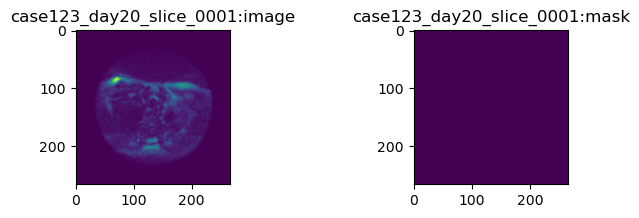

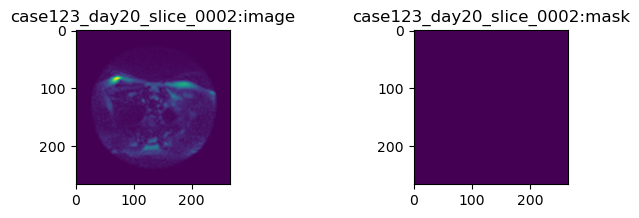

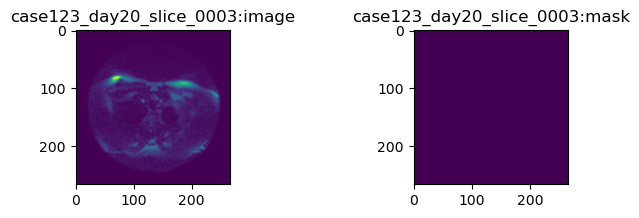

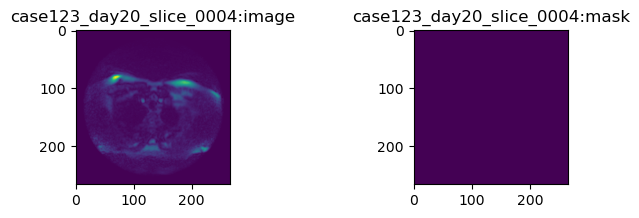

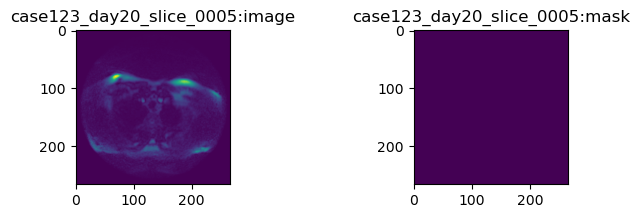

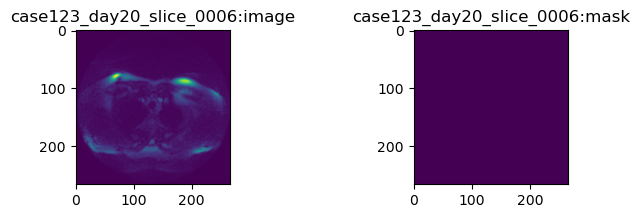

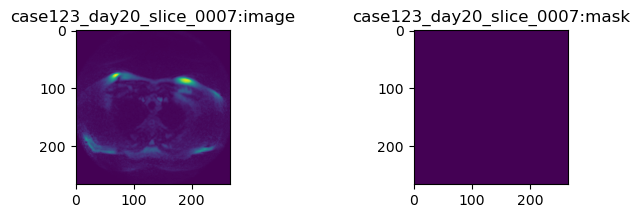

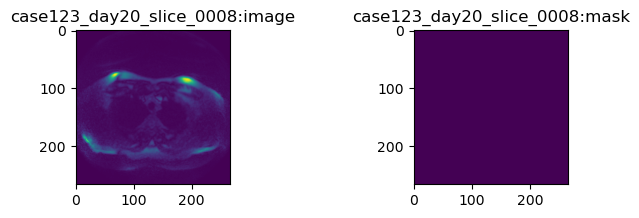

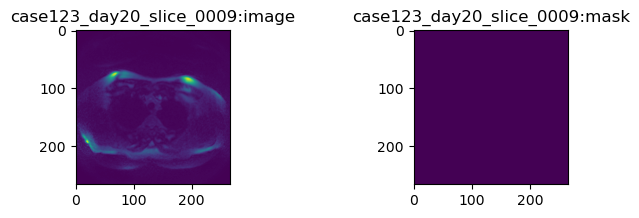

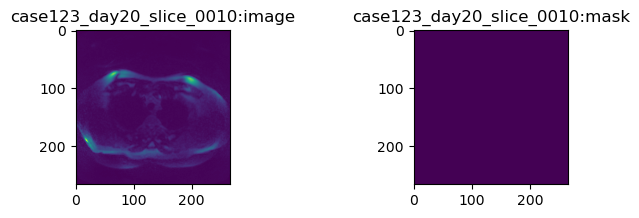

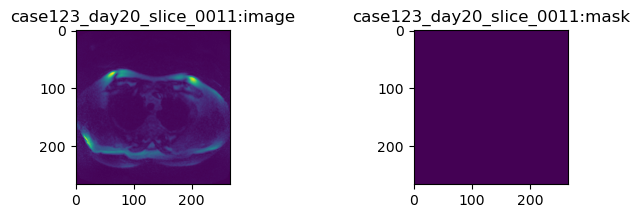

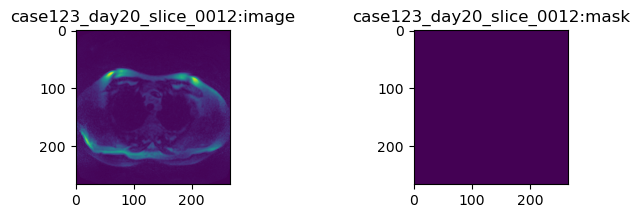

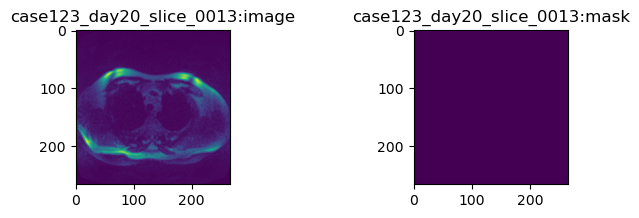

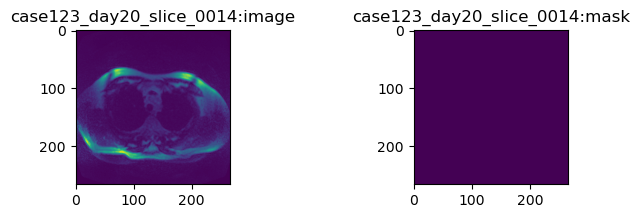

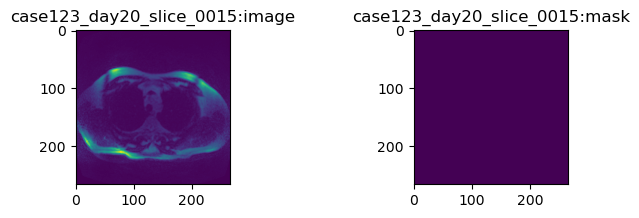

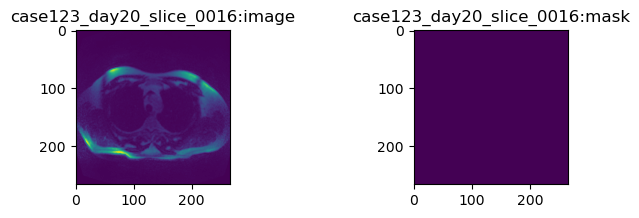

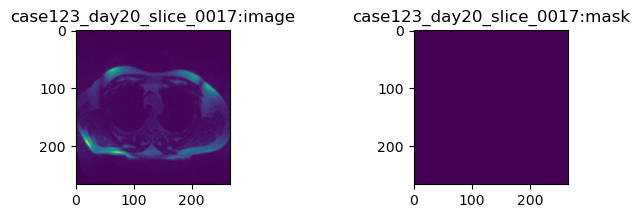

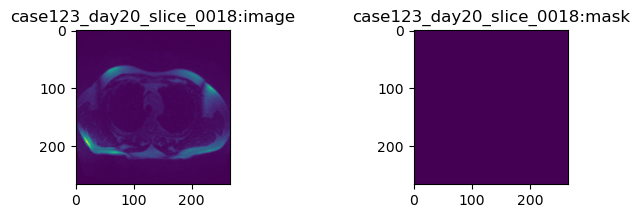

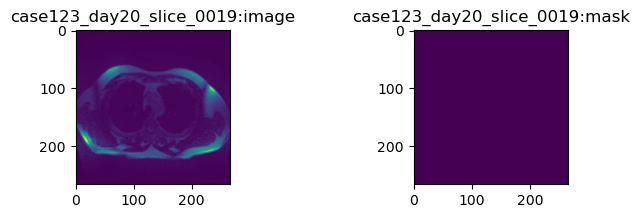

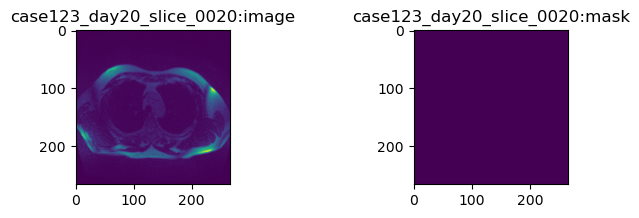

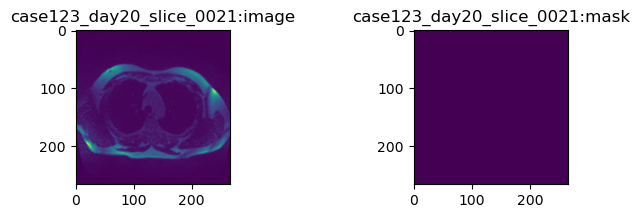

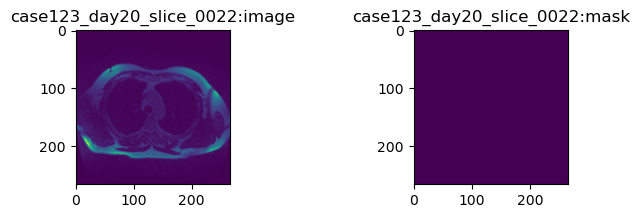

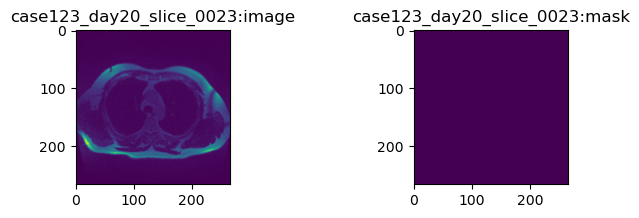

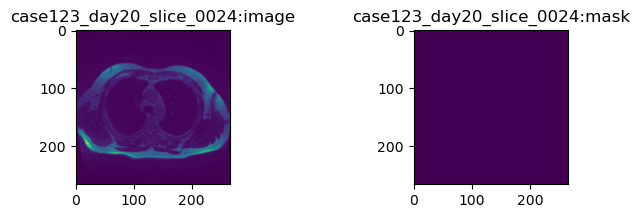

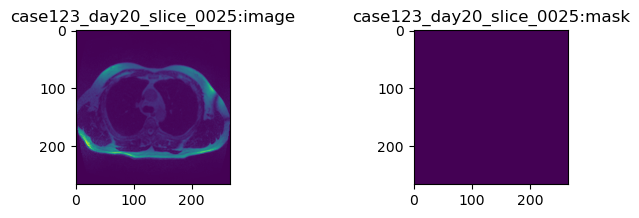

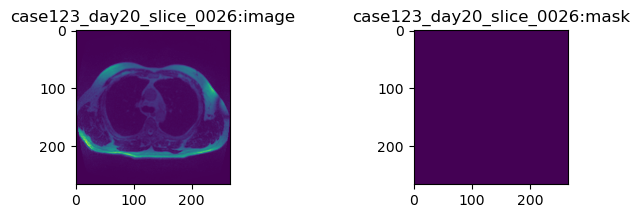

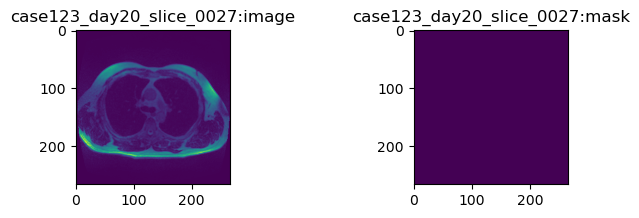

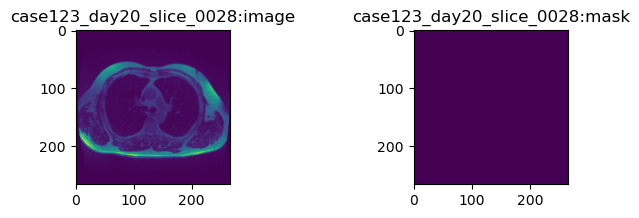

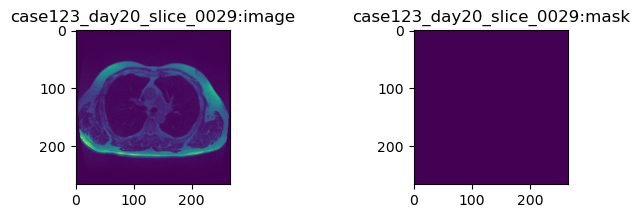

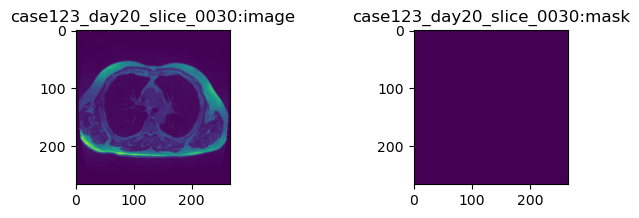

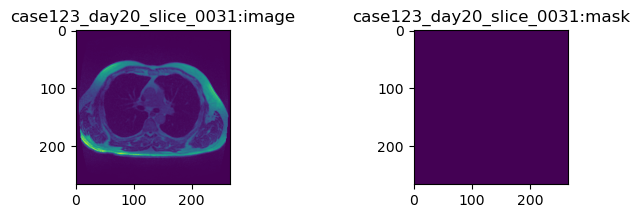

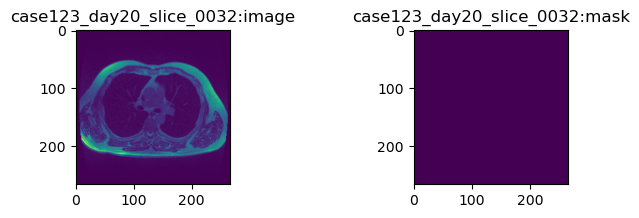

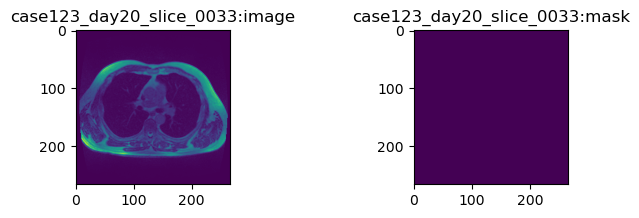

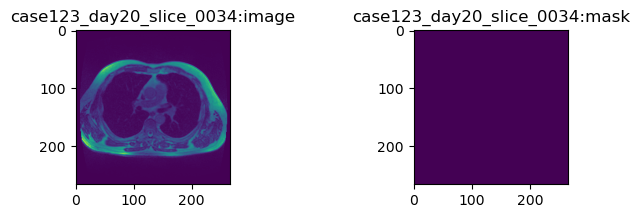

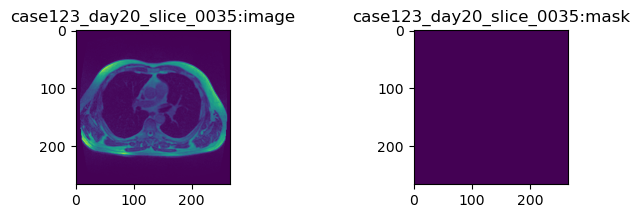

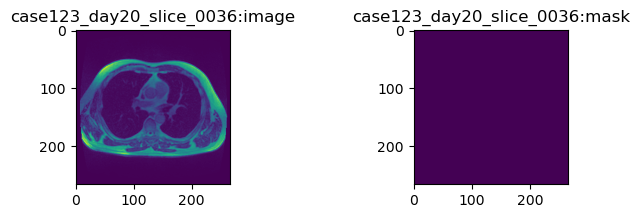

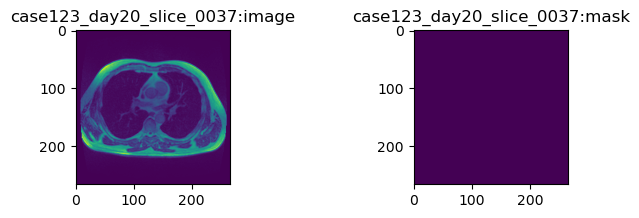

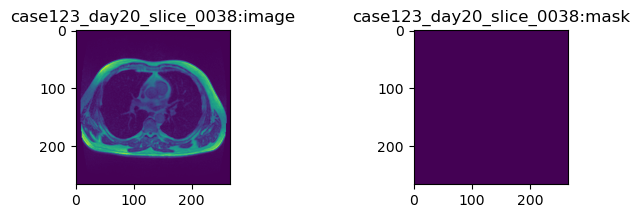

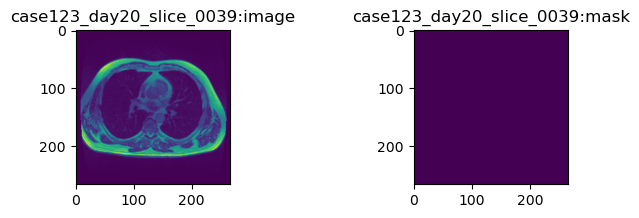

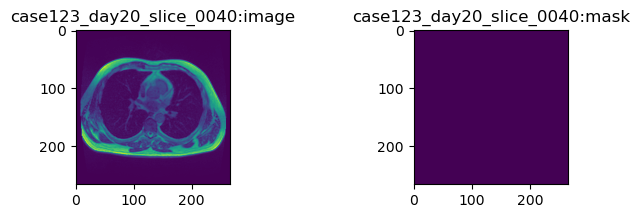

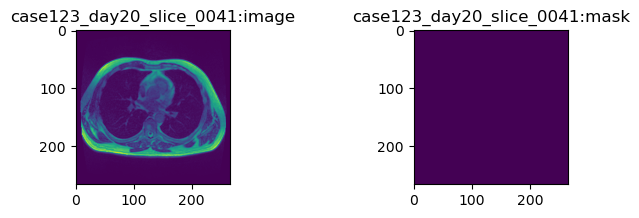

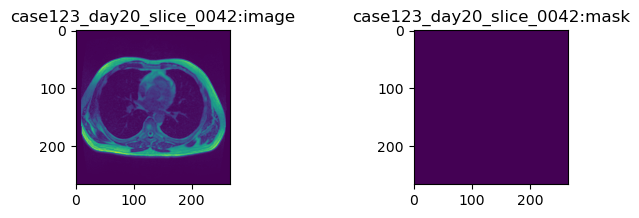

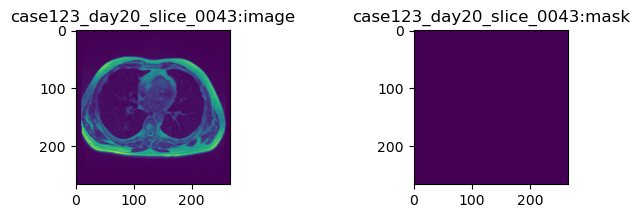

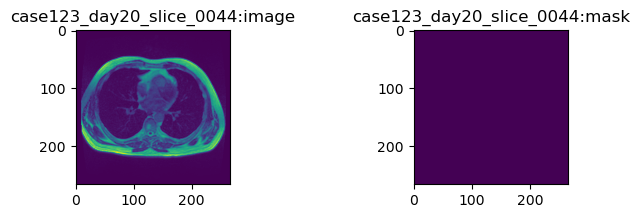

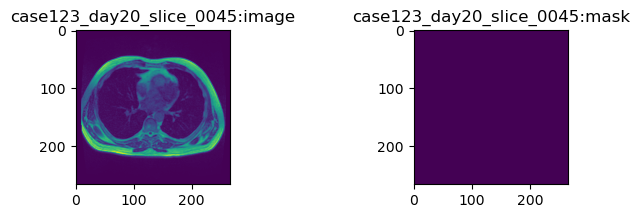

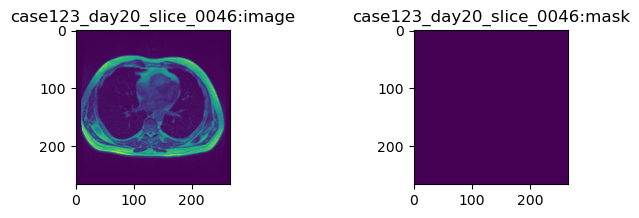

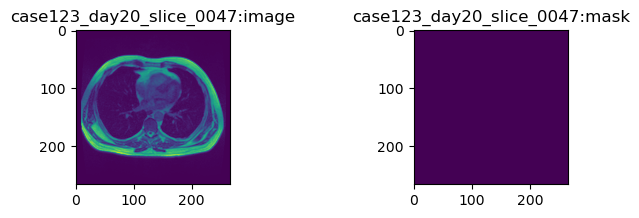

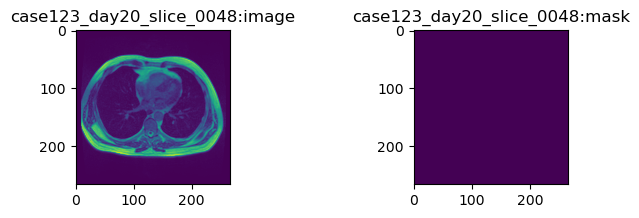

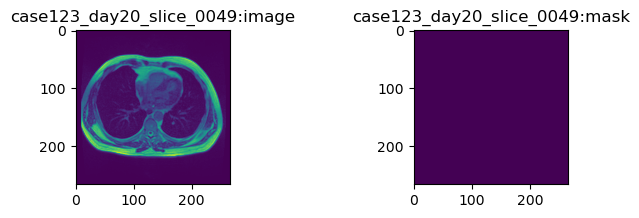

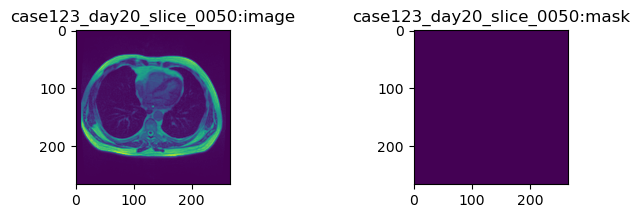

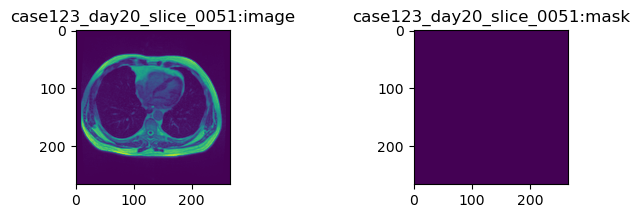

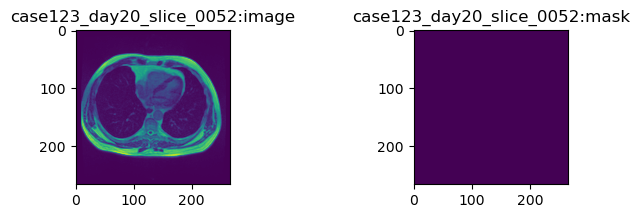

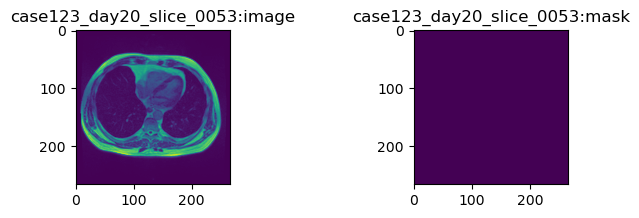

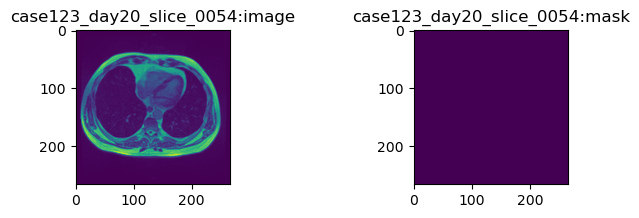

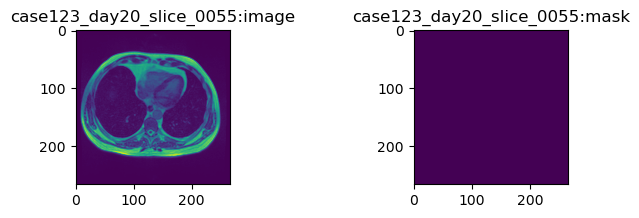

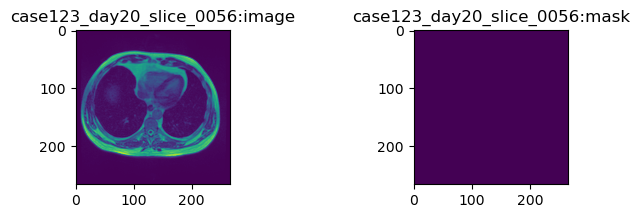

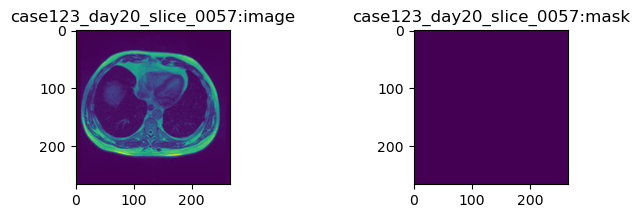

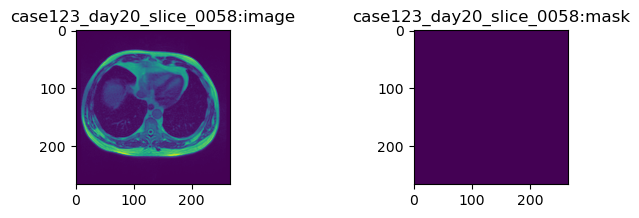

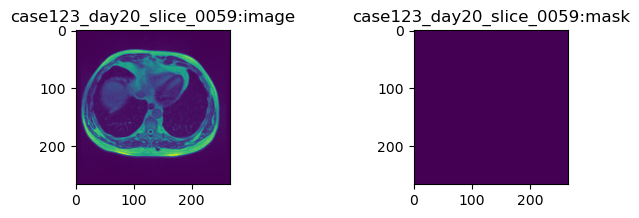

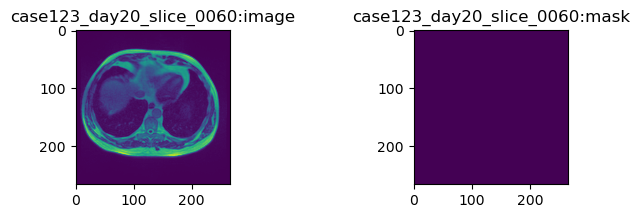

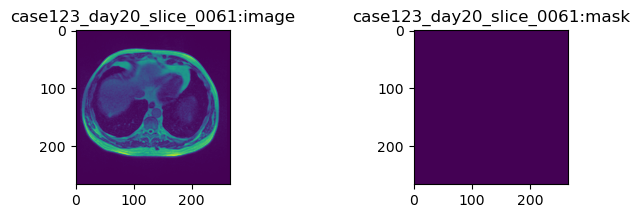

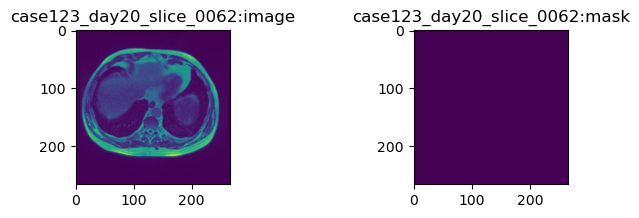

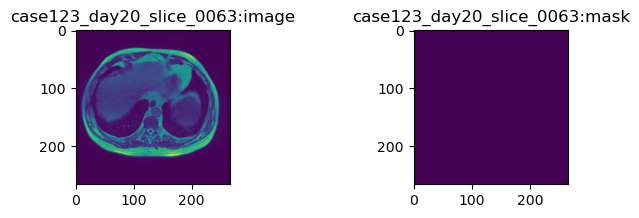

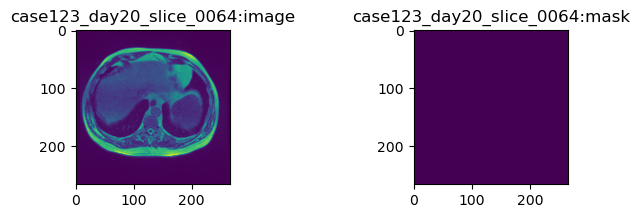

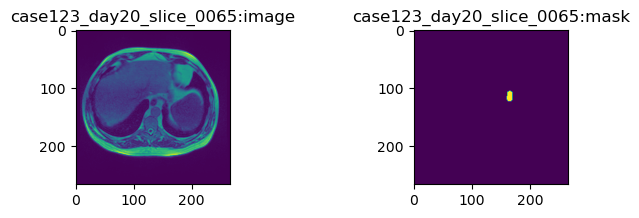

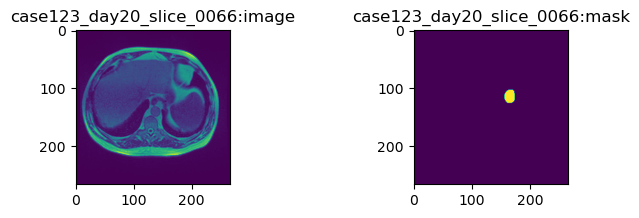

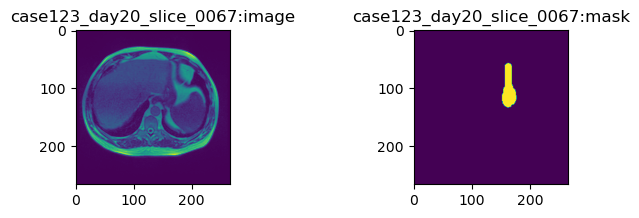

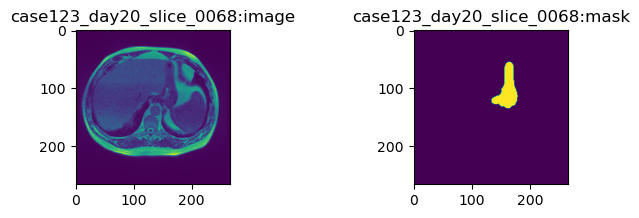

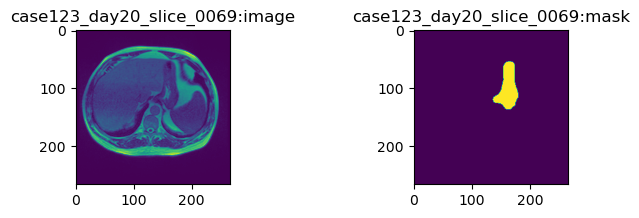

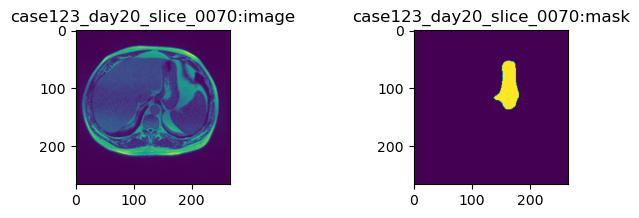

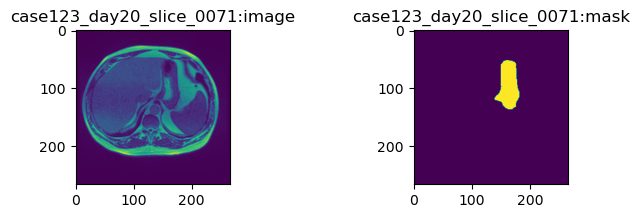

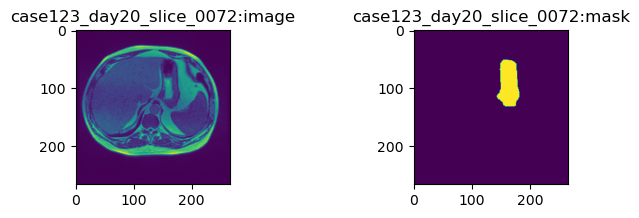

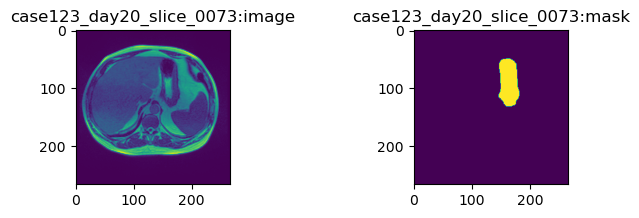

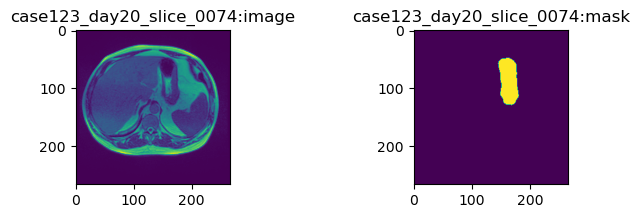

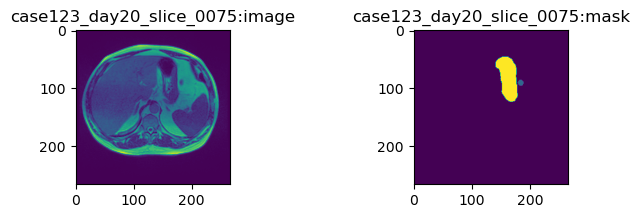

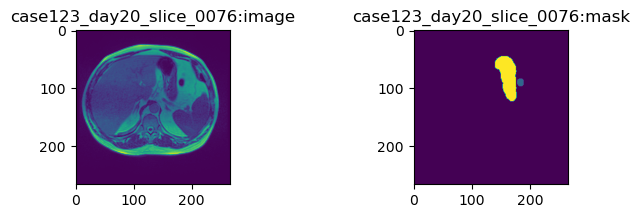

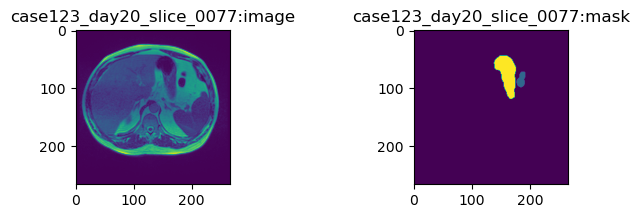

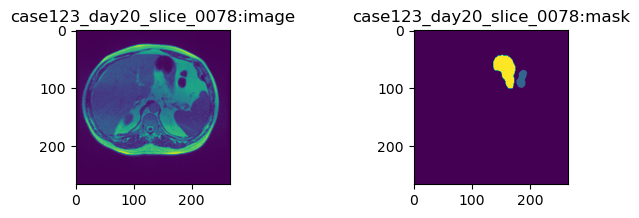

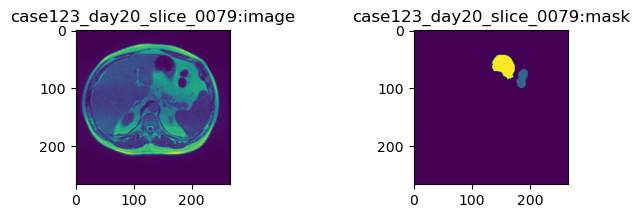

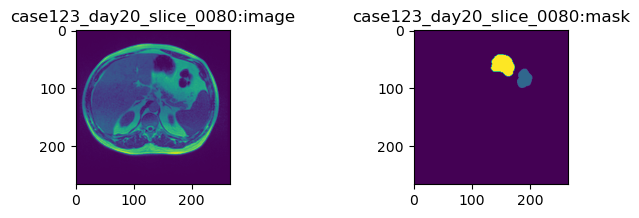

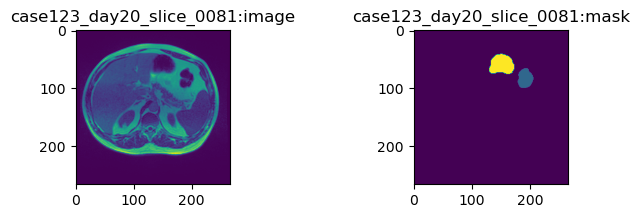

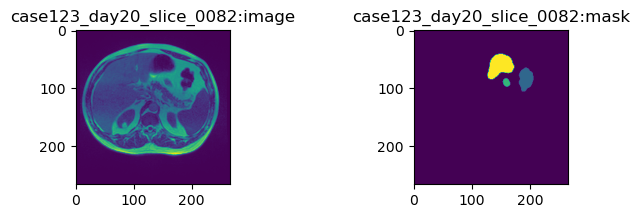

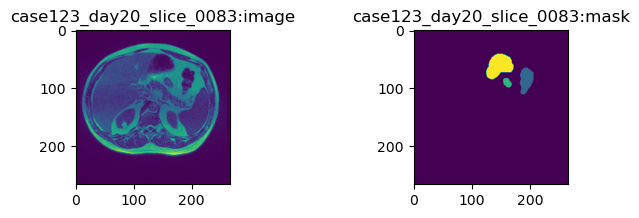

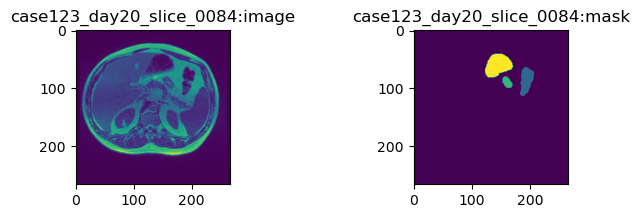

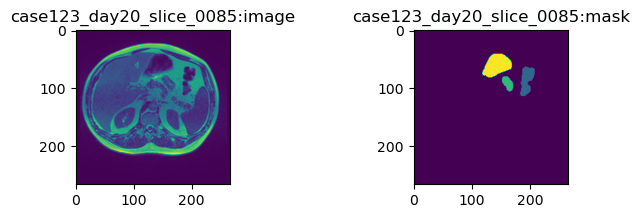

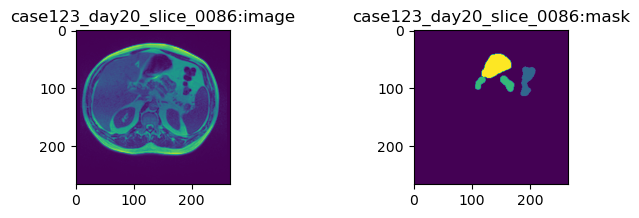

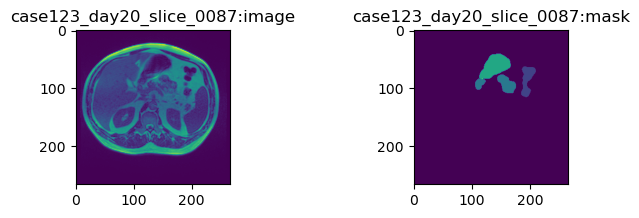

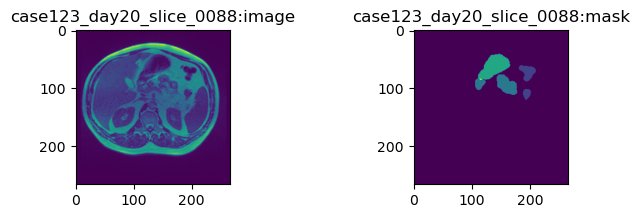

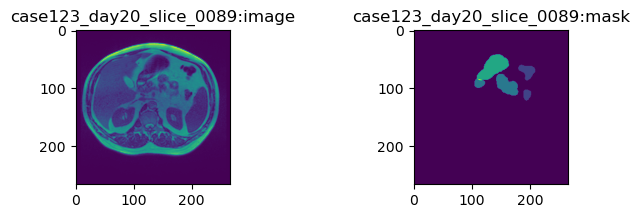

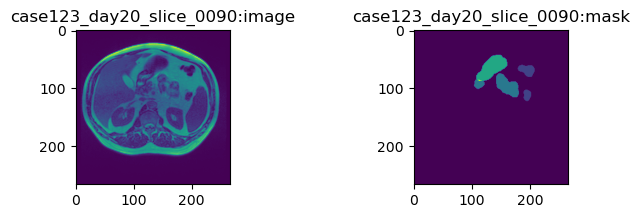

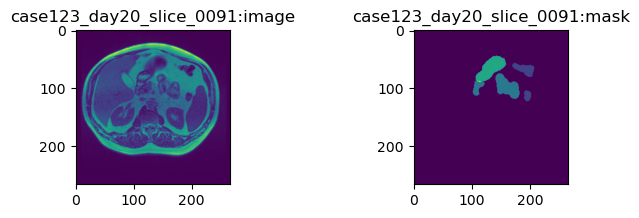

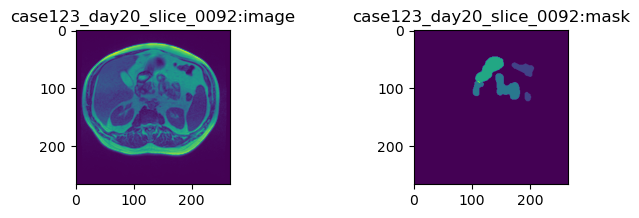

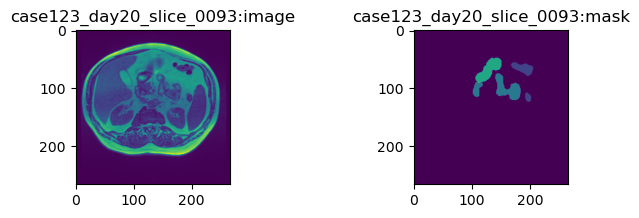

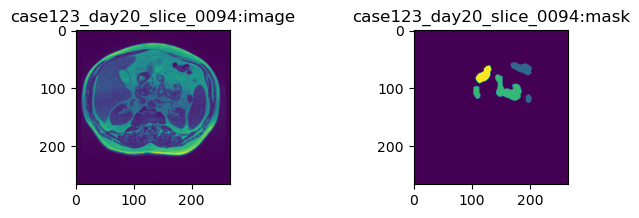

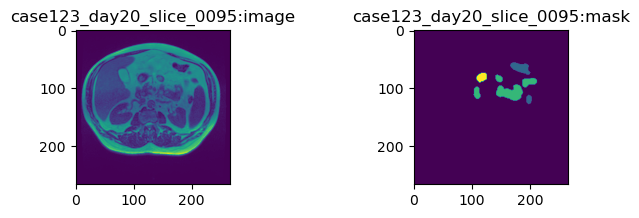

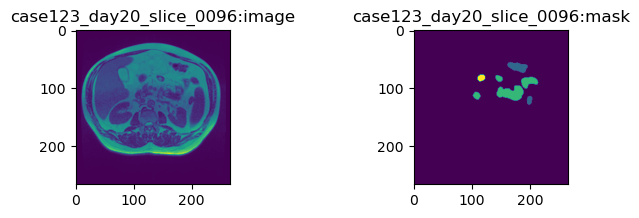

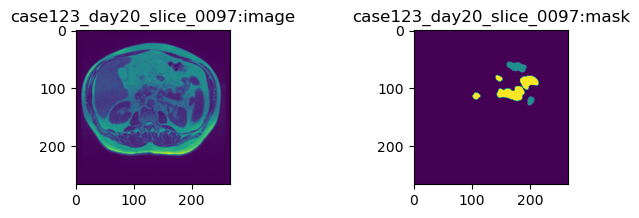

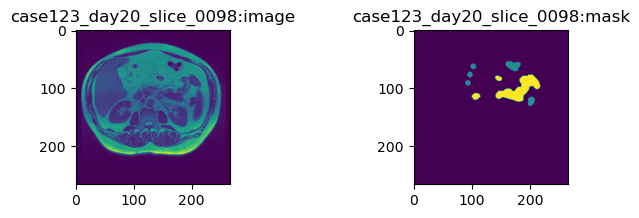

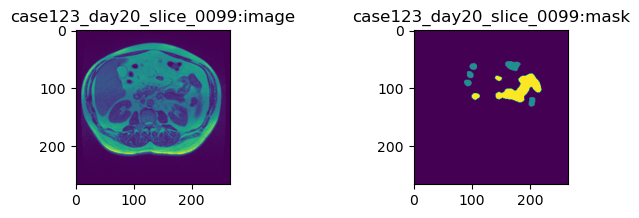

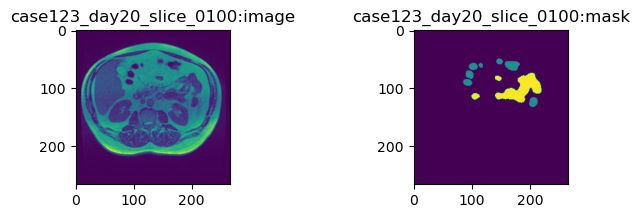

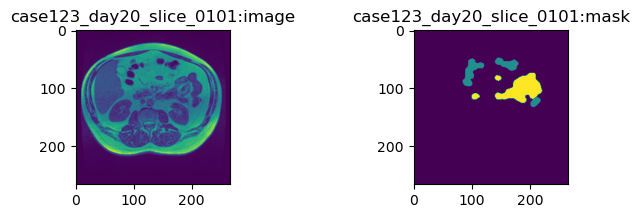

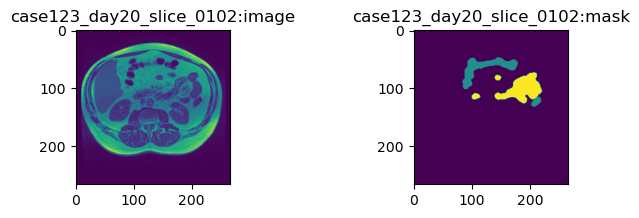

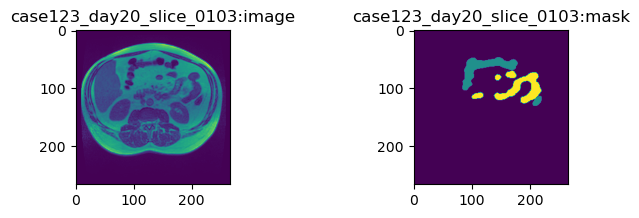

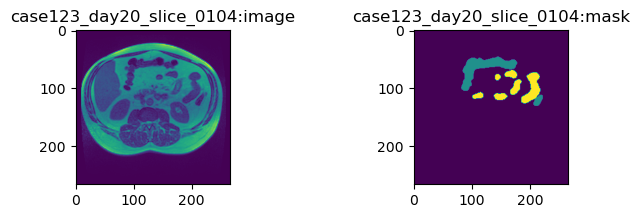

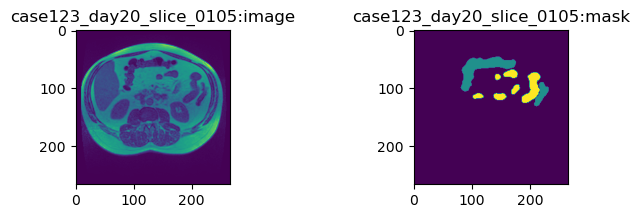

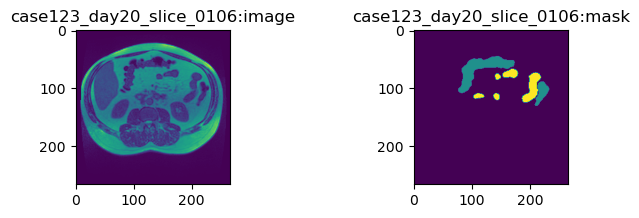

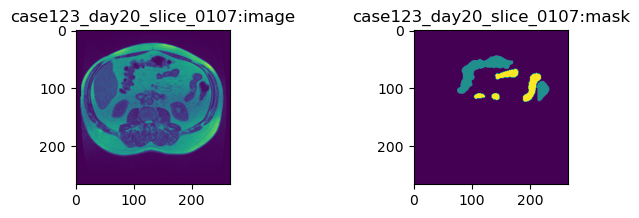

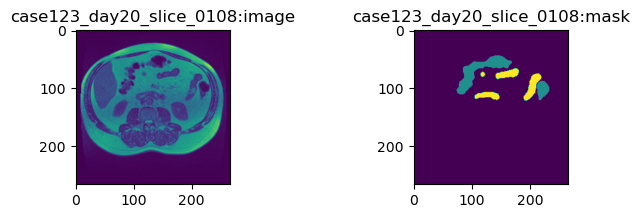

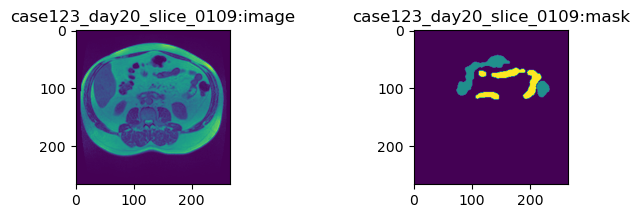

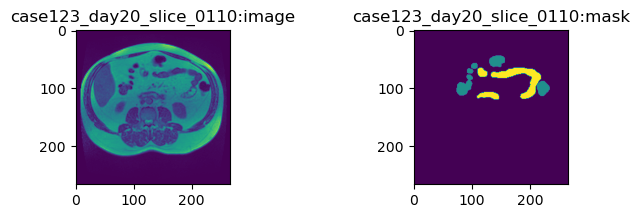

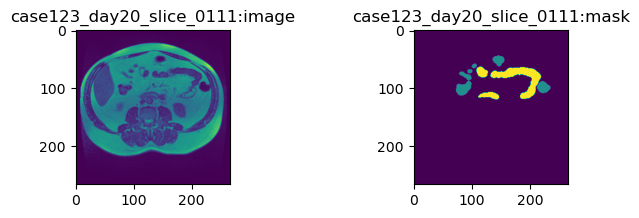

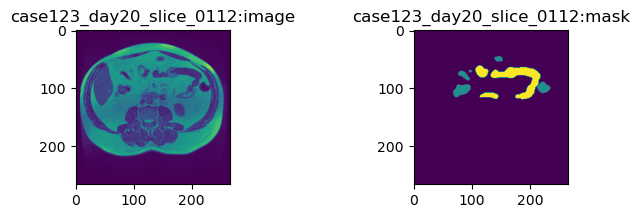

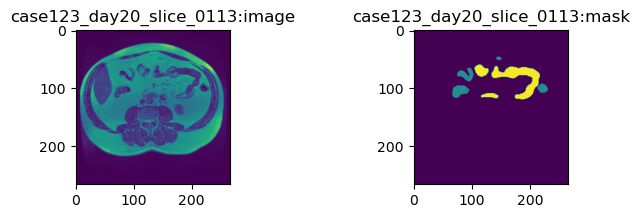

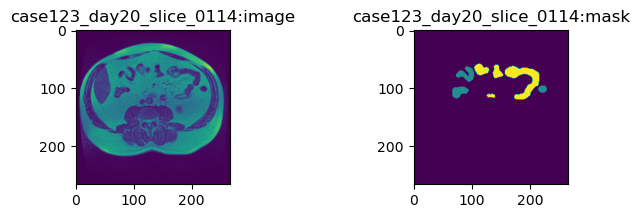

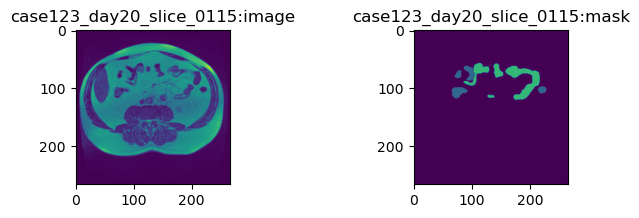

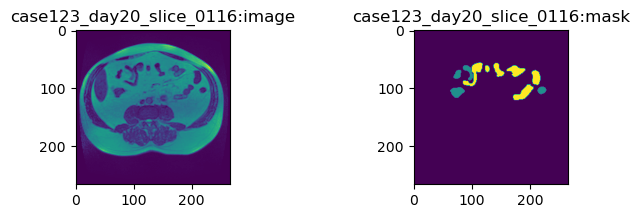

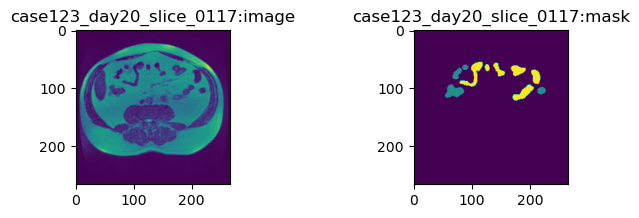

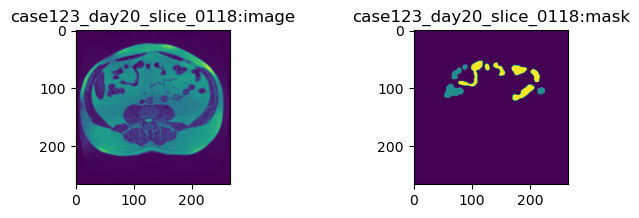

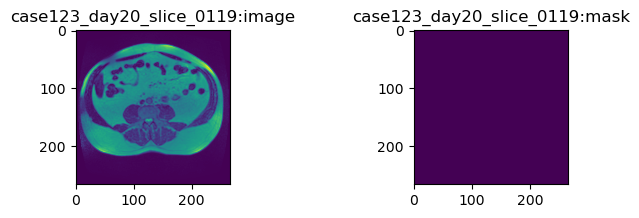

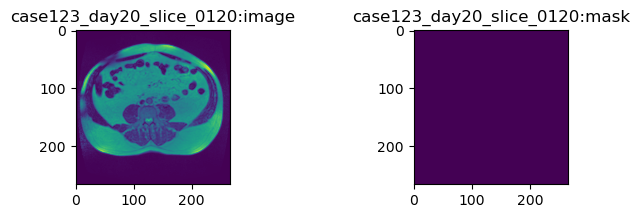

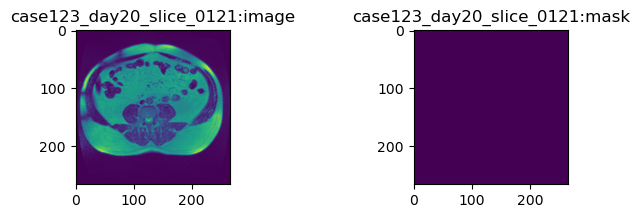

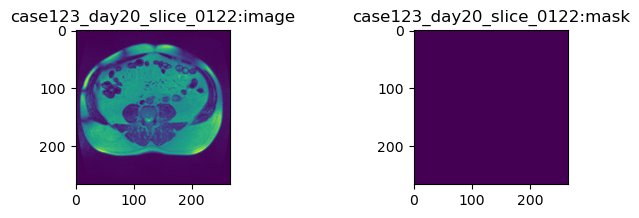

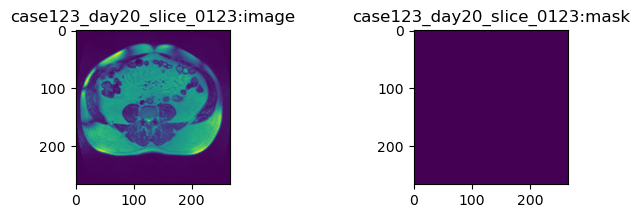

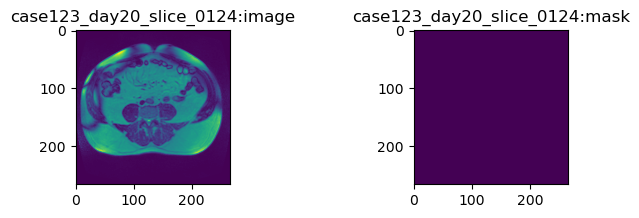

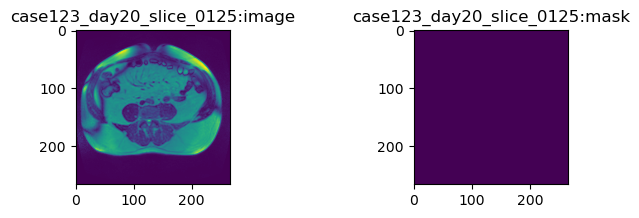

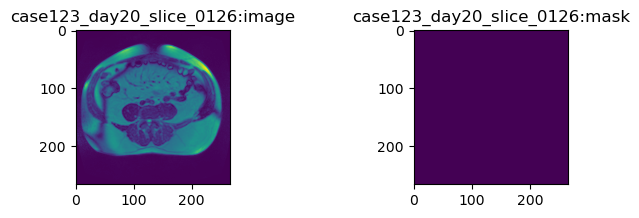

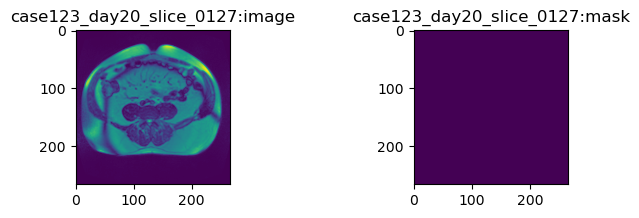

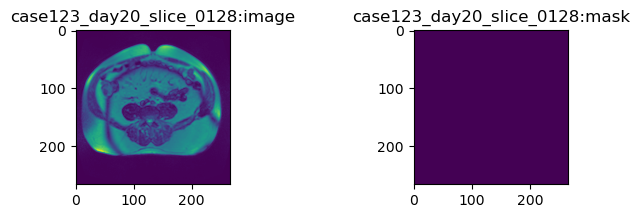

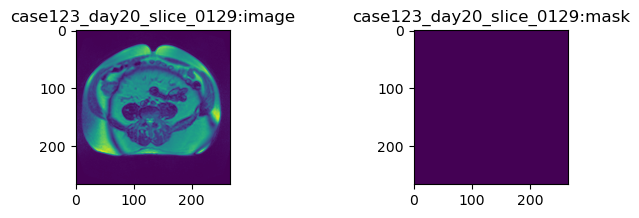

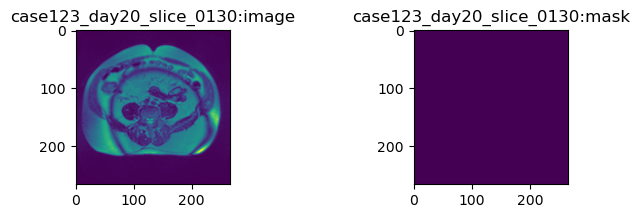

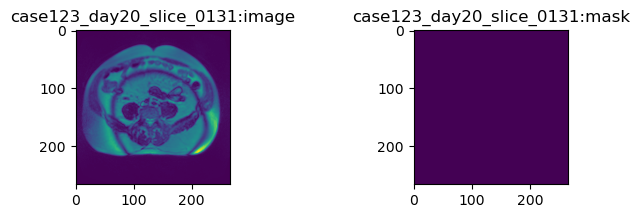

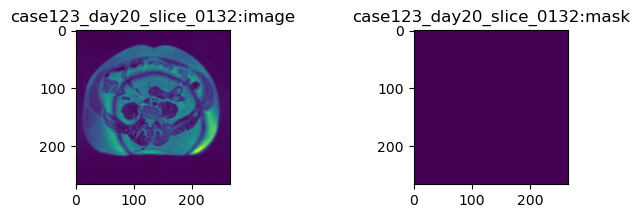

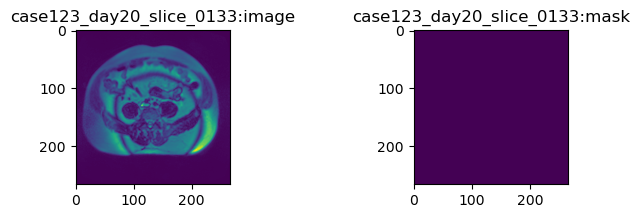

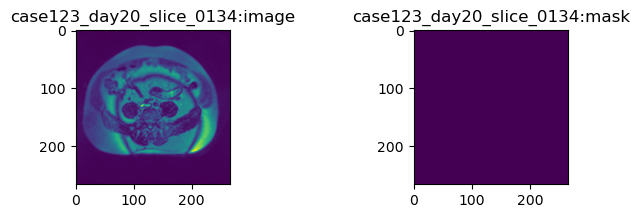

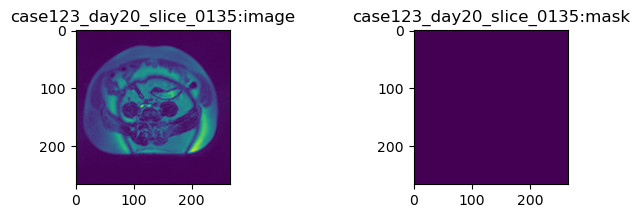

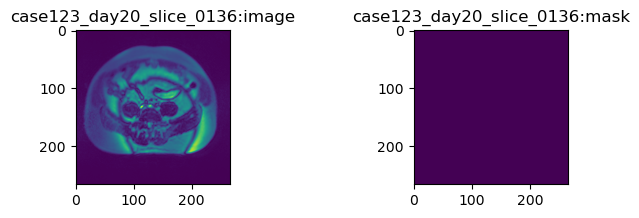

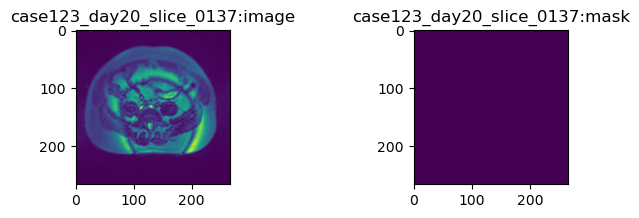

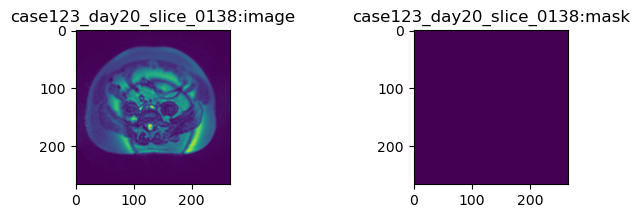

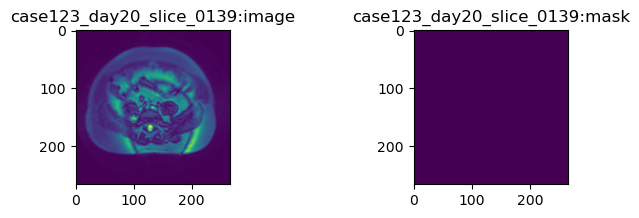

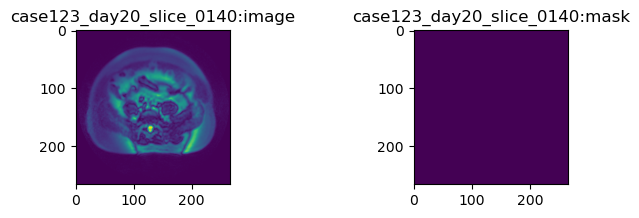

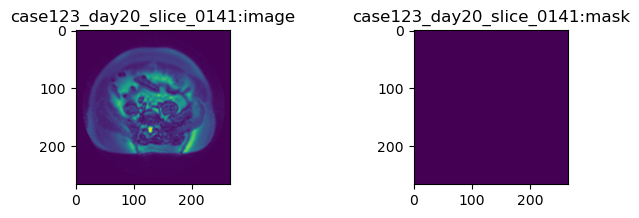

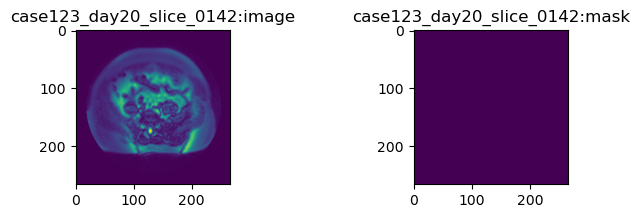

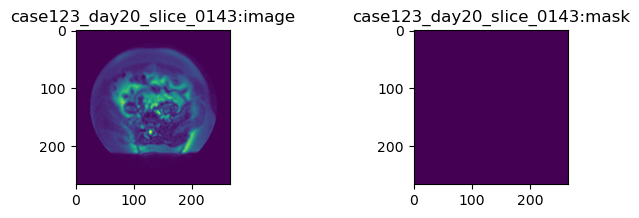

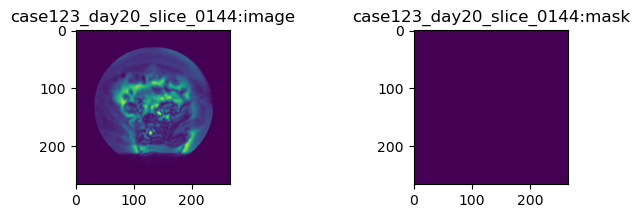

In [20]:
case = 'case123'
day = 'day20'
key = case + "_" + day + "_" # 用心のため，最後にアンダースコアを付与
slice_list = df[df['id'].str.startswith(key)]['id'].unique()

for slice in slice_list:
    # 動作チェック
    image, mask, large_bowel, small_bowel, stomach = load_image(df, target_slice=slice)

    fig = plt.figure(figsize=(8, 2))
    
    ax1 = fig.add_subplot(1, 2, 1)
    plt.title('{}:image'.format(slice))
    plt.imshow(image)
    
    ax2 = fig.add_subplot(1, 2, 2)
    plt.title('{}:mask'.format(slice))
    plt.imshow(mask)

    '''
    ax3 = fig.add_subplot(2, 3, 4)
    plt.title('large_bowel')
    plt.imshow(large_bowel)
    
    ax4 = fig.add_subplot(2, 3, 5)
    plt.title('small_bowel')
    plt.imshow(small_bowel)
    
    ax5 = fig.add_subplot(2, 3, 6)
    plt.title('stomach')
    plt.imshow(stomach)
    '''
    
    # plt.show()
    plt.savefig(f"{slice}.png")